# Post-processing

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression

VIDEO_NUMBER = "7"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_{VIDEO_NUMBER}.csv")
INPUT_ORIGINAL_CSV = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_new_{VIDEO_NUMBER}.csv")

In [271]:
def show_plots(df):
    # Create subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot x_axis
    axes[0].scatter(df['frame'], df['x_axis'], color='r')
    axes[0].set_title('X Axis per Frame')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('x_axis')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True)

    # Plot y_axis
    axes[1].scatter(df['frame'], df['y_axis'], color='g')
    axes[1].set_title('Y Axis per Frame')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('y_axis')
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True)

    # Plot z_axis
    axes[2].scatter(df['frame'], df['z_axis'], color='b')
    axes[2].set_title('Z Axis per Frame')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylabel('z_axis')
    axes[2].set_ylim(-1.1, 1.1)
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

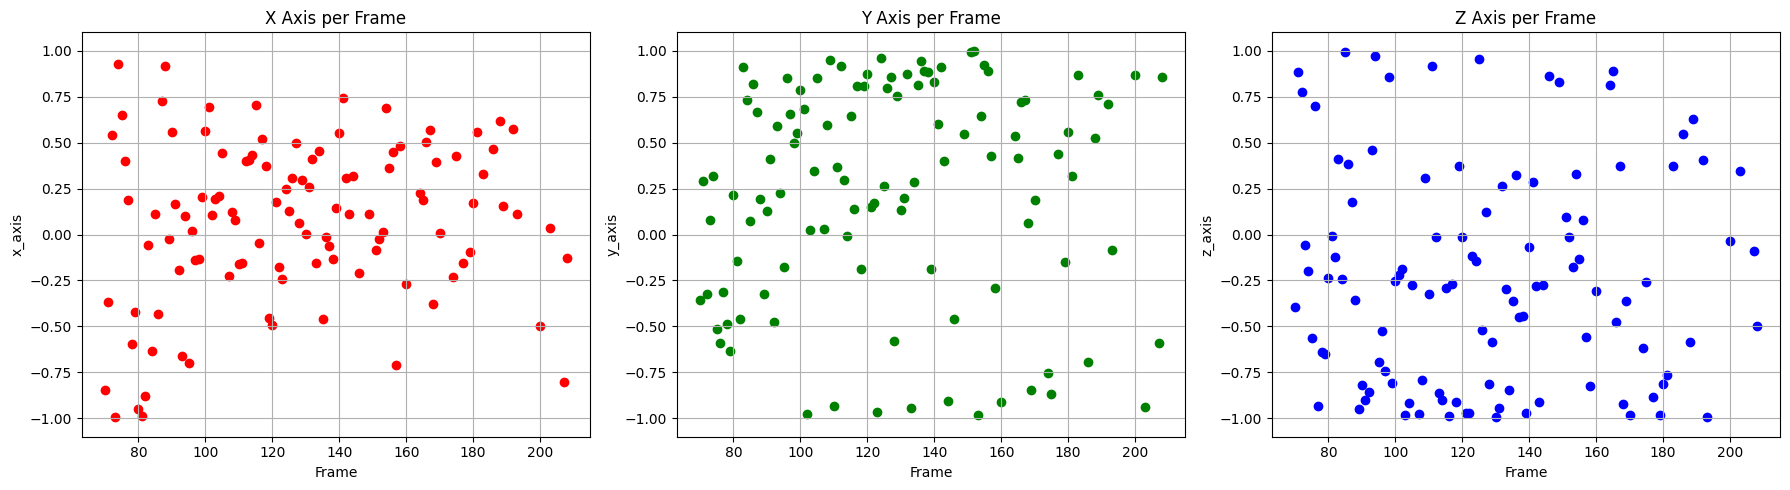

In [272]:
# Read the CSV data
df = pd.read_csv(INPUT_CSV_PATH)

show_plots(df)

Average z_axis value: -0.23465001556283868
Transformed rows where z_axis > 0.


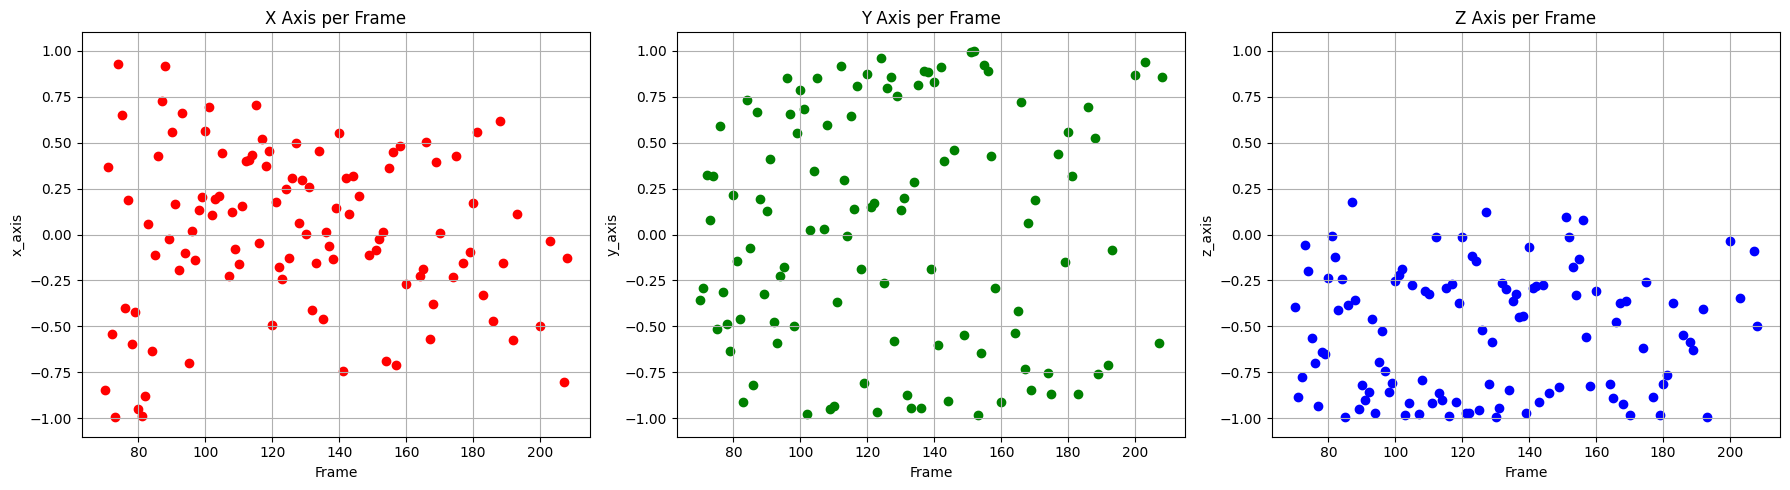

In [273]:
# Calculate average of z_axis
z_axis_avg = df['z_axis'].mean()

# Print the result
print(f"Average z_axis value: {z_axis_avg}")

if z_axis_avg < 0:
    # For rows where z_axis > 0, change the sign of x_axis, y_axis, and z_axis
    df.loc[df['z_axis'] > 0.25, ['x_axis', 'y_axis', 'z_axis']] *= -1
    print("Transformed rows where z_axis > 0.")
else:
    # For rows where z_axis < 0, change the sign of x_axis, y_axis, and z_axis
    df.loc[df['z_axis'] < 0.25, ['x_axis', 'y_axis', 'z_axis']] *= -1
    print("Transformed rows where z_axis < 0.")

show_plots(df)

Average y_axis value: 0.038375200215111545
Cleaned 49 rows where y_axis was outside the acceptable range.


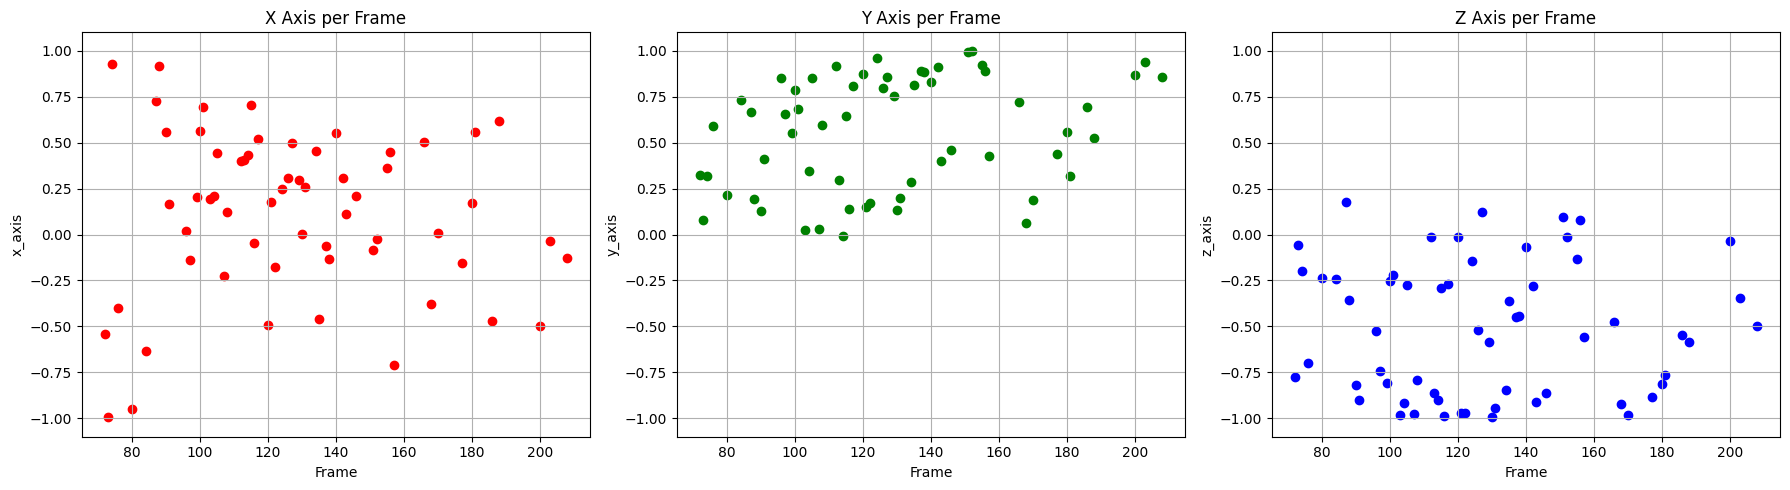

In [274]:
# y_axis_avg = df['y_axis'].mean()

# # Print the result
# print(f"Average y_axis value: {y_axis_avg}")

# if y_axis_avg < 0:
#     # Remove rows where y_axis > 0
#     df_y = df[df['y_axis'] <= -y_axis_avg].reset_index(drop=True)
#     removed = len(df) - len(df_y)
#     print(f"Removed {removed} rows where y_axis > 0.")
# else:
#     df_y = df[df['y_axis'] >= -y_axis_avg].reset_index(drop=True)
#     removed = len(df) - len(df_y)
#     print(f"Removed {removed} rows where y_axis < 0.")

y_axis_avg = df['y_axis'].mean()
print(f"Average y_axis value: {y_axis_avg}")

df_y = df.copy()

if y_axis_avg < 0:
    condition = df_y['y_axis'] > -y_axis_avg
else:
    condition = df_y['y_axis'] < -y_axis_avg

# Set values to NaN where the condition is met
columns_to_clean = ['x_axis', 'y_axis', 'z_axis', 'angle']
df_y.loc[condition, columns_to_clean] = np.nan

# Report how many rows were affected
cleaned = condition.sum()
print(f"Cleaned {cleaned} rows where y_axis was outside the acceptable range.")


show_plots(df_y)

Average x_axis value: 0.11146345326488294
Cleaned 22 rows where x_axis was outside the acceptable range.


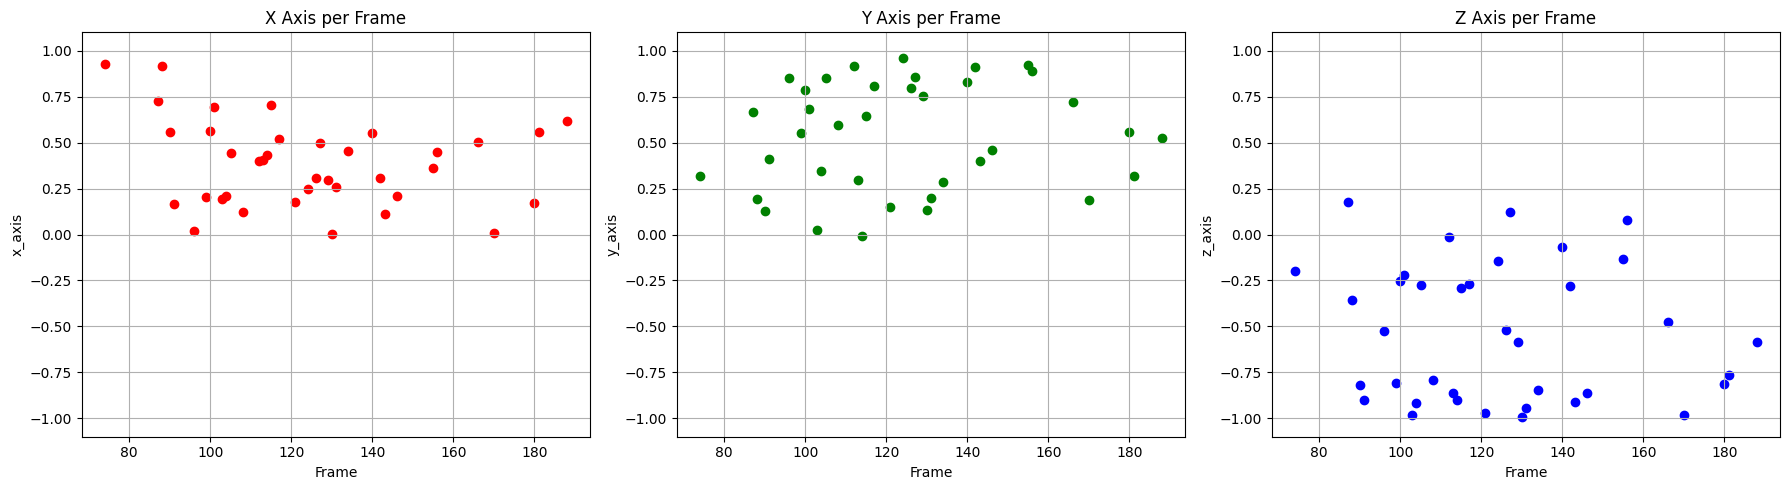

In [275]:
# x_axis_avg = df_y['x_axis'].mean()

# # Print the result
# print(f"Average x_axis value: {x_axis_avg}")

# if x_axis_avg < 0:
#     # Remove rows where y_axis > 0
#     df_x = df_y[df_y['x_axis'] <= -x_axis_avg].reset_index(drop=True)
#     removed = len(df_y) - len(df_x)
#     print(f"Removed {removed} rows where x_axis > 0.")
# else:
#     df_x = df_y[df_y['x_axis'] >= -x_axis_avg].reset_index(drop=True)
#     removed = len(df_y) - len(df_x)
#     print(f"Removed {removed} rows where x_axis < 0.")

import numpy as np

x_axis_avg = df_y['x_axis'].mean()
print(f"Average x_axis value: {x_axis_avg}")

df_x = df_y.copy()

if x_axis_avg < 0:
    condition = df_x['x_axis'] > -x_axis_avg +0.1
else:
    condition = df_x['x_axis'] < -x_axis_avg +0.1

# Set target columns to NaN where condition is met
columns_to_clean = ['x_axis', 'y_axis', 'z_axis', 'angle']
df_x.loc[condition, columns_to_clean] = np.nan

# Report cleaned rows
cleaned = condition.sum()
print(f"Cleaned {cleaned} rows where x_axis was outside the acceptable range.")


show_plots(df_x)

In [276]:
def show_plots_with_regression(full_df, filtered_df, threshold):
    # Drop rows with NaNs for regression fitting
    reg_df = full_df.dropna(subset=['frame', 'x_axis', 'y_axis'])

    # Fit regression lines on clean data
    x_model = LinearRegression()
    y_model = LinearRegression()
    x_model.fit(reg_df[['frame']], reg_df['x_axis'])
    y_model.fit(reg_df[['frame']], reg_df['y_axis'])

    # Predict over the same frames used in regression
    frames = reg_df['frame'].values.reshape(-1, 1)
    x_line = x_model.predict(frames)
    y_line = y_model.predict(frames)

    # Compute prediction errors only on reg_df
    x_error = np.abs(reg_df['x_axis'].values - x_line)
    y_error = np.abs(reg_df['y_axis'].values - y_line)
    is_outlier = (x_error > threshold) | (y_error > threshold)

    # Create subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # X Axis plot
    axes[0].scatter(reg_df['frame'][~is_outlier], reg_df['x_axis'][~is_outlier], color='green', label='Kept')
    axes[0].scatter(reg_df['frame'][is_outlier], reg_df['x_axis'][is_outlier], color='red', label='Outlier')
    axes[0].plot(reg_df['frame'], x_line, color='black', linestyle='--', label='Fit Line')
    axes[0].set_title('X Axis per Frame')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('x_axis')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True)
    axes[0].legend()

    # Y Axis plot
    axes[1].scatter(reg_df['frame'][~is_outlier], reg_df['y_axis'][~is_outlier], color='green', label='Kept')
    axes[1].scatter(reg_df['frame'][is_outlier], reg_df['y_axis'][is_outlier], color='red', label='Outlier')
    axes[1].plot(reg_df['frame'], y_line, color='black', linestyle='--', label='Fit Line')
    axes[1].set_title('Y Axis per Frame')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('y_axis')
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True)
    axes[1].legend()

    # Z Axis plot (just show values from full_df)
    axes[2].scatter(full_df['frame'], full_df['z_axis'], color='b')
    axes[2].set_title('Z Axis per Frame')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylabel('z_axis')
    axes[2].set_ylim(-1.1, 1.1)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


In [277]:
def remove_outliers(df, threshold=0.50):
    df = df.copy()

    # Identify rows where x_axis and y_axis are valid
    valid_mask = df['x_axis'].notna() & df['y_axis'].notna()

    # Subset for regression
    valid_df = df[valid_mask]

    # Fit a line to x_axis vs frame
    x_model = LinearRegression()
    x_model.fit(valid_df[['frame']], valid_df['x_axis'])
    x_pred = x_model.predict(valid_df[['frame']])

    # Fit a line to y_axis vs frame
    y_model = LinearRegression()
    y_model.fit(valid_df[['frame']], valid_df['y_axis'])
    y_pred = y_model.predict(valid_df[['frame']])

    # Compute errors only for valid rows
    x_error = np.abs(valid_df['x_axis'] - x_pred)
    y_error = np.abs(valid_df['y_axis'] - y_pred)

    # Mask of values within threshold
    within_threshold = (x_error <= threshold) & (y_error <= threshold)

    # Set outliers in original DataFrame to NaN
    outlier_indices = valid_df.index[~within_threshold]
    df.loc[outlier_indices, ['x_axis', 'y_axis', 'z_axis', 'angle']] = np.nan

    # Report
    print(f"Cleaned {len(outlier_indices)} outlier rows based on threshold {threshold}.")

    return df

Cleaned 1 outlier rows based on threshold 0.5.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


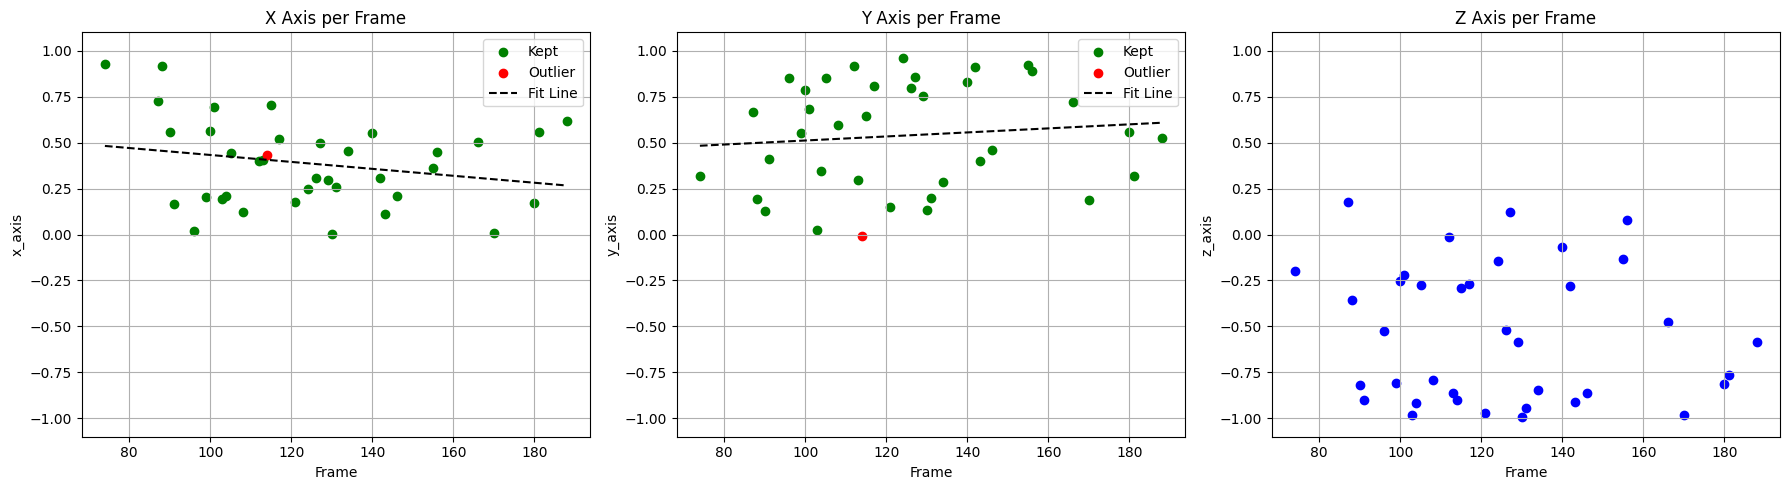

In [278]:
threshold = 0.5
fil_df = remove_outliers(df_x, threshold)

show_plots_with_regression(full_df=df_x, filtered_df=fil_df, threshold=threshold)

Cleaned 18 outlier rows based on threshold 0.3.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


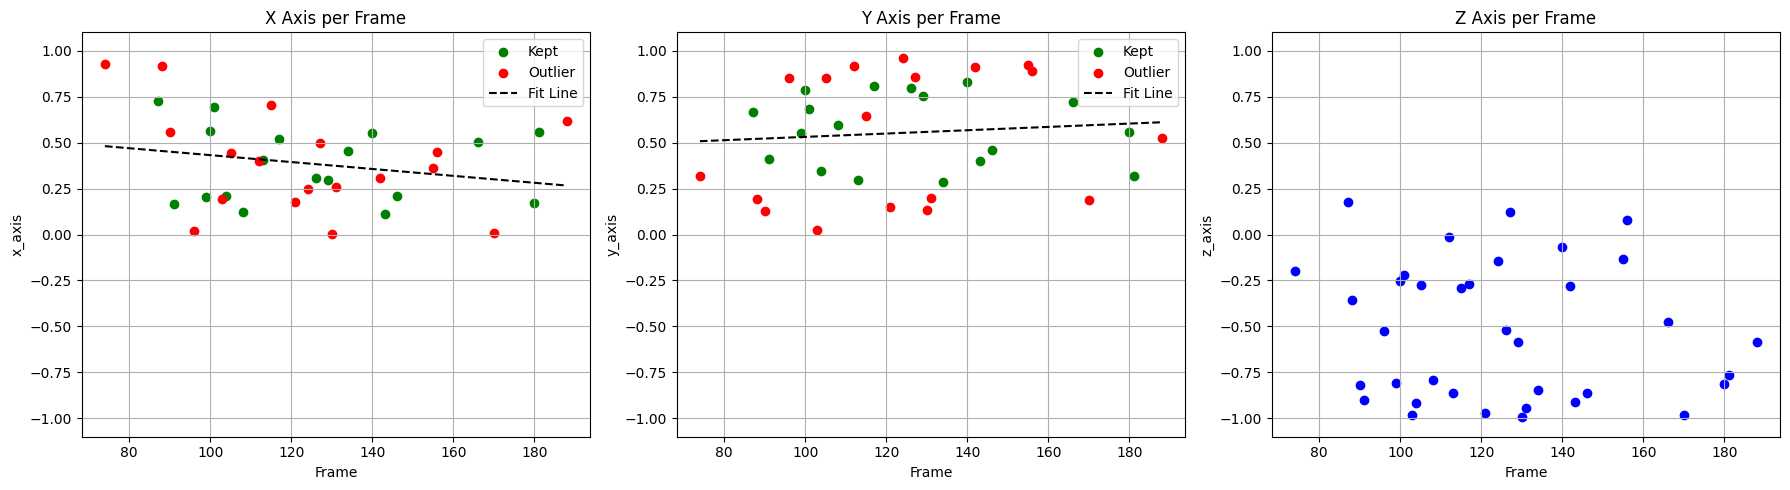

In [279]:
threshold = 0.3
filt_df = remove_outliers(fil_df, threshold)

show_plots_with_regression(full_df=fil_df, filtered_df=filt_df, threshold=threshold)

Cleaned 2 outlier rows based on threshold 0.3.


/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/davic/projects/IACV_project/bowling-analysis/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


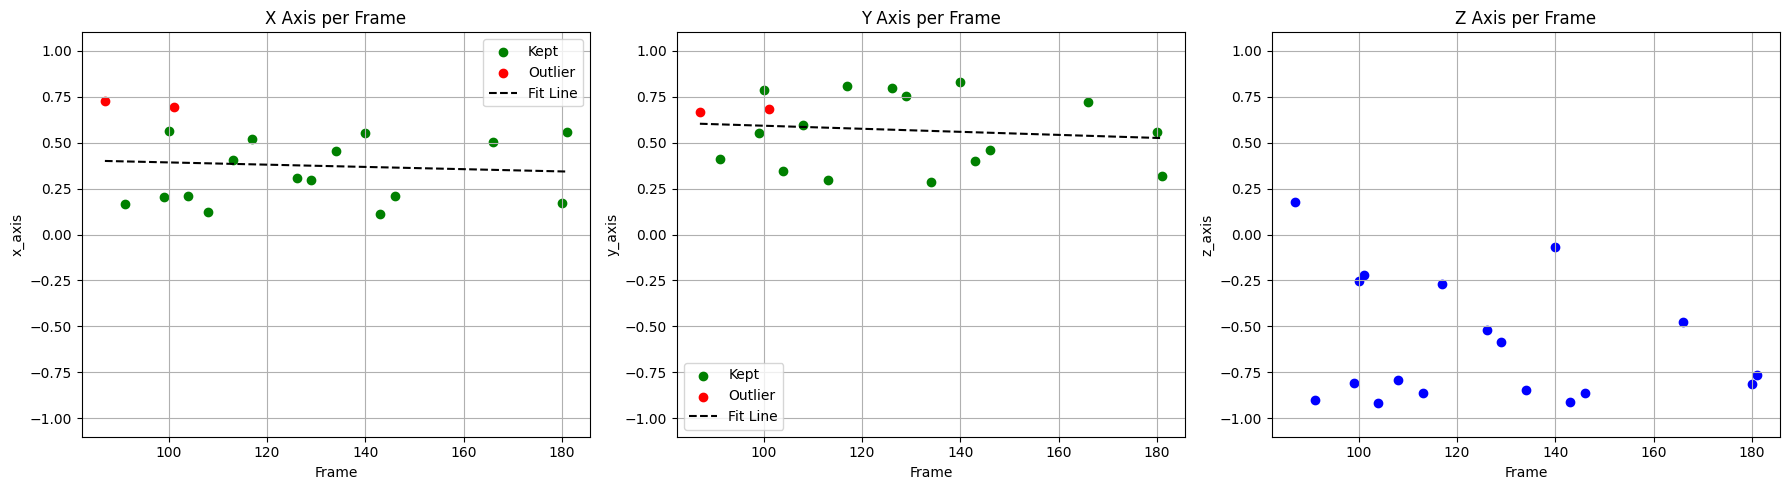

In [280]:
threshold = 0.3
filtered_df = remove_outliers(filt_df, threshold)

show_plots_with_regression(full_df=filt_df, filtered_df=filtered_df, threshold=threshold)

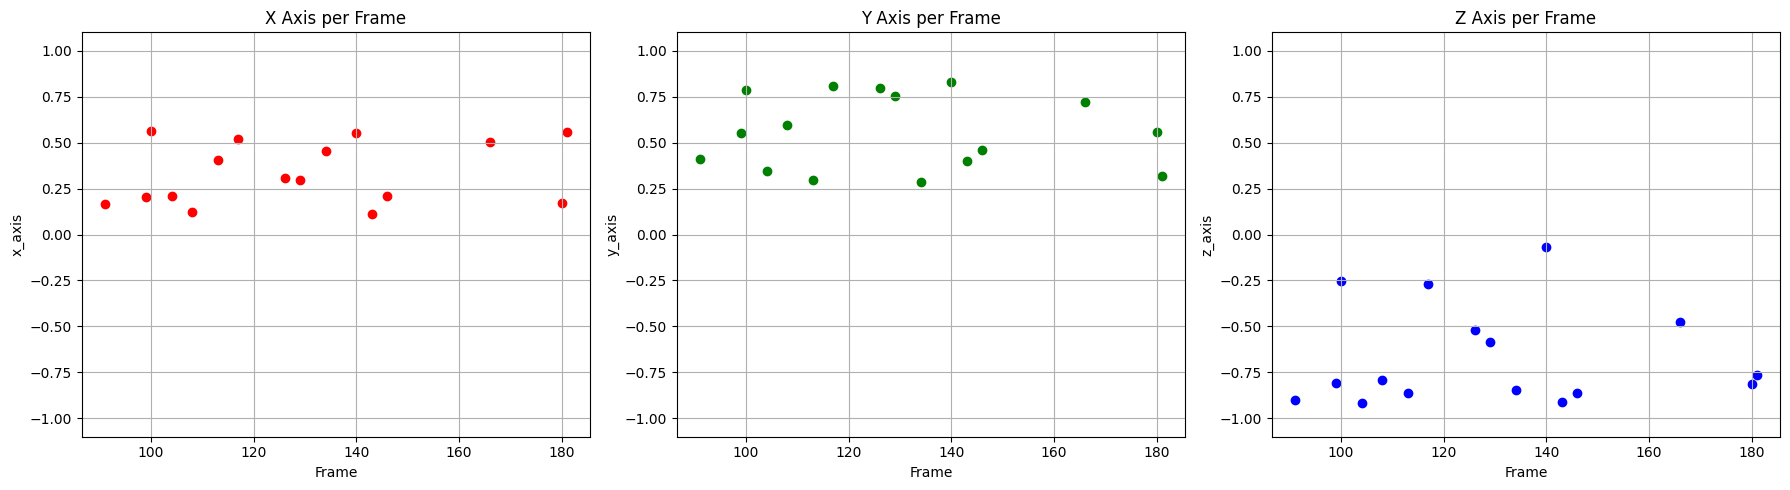

In [281]:
show_plots(filtered_df)

In [282]:
filtered_df.head

<bound method NDFrame.head of      frame   x   y  radius  x_axis  y_axis  z_axis  angle
0        0 NaN NaN     NaN     NaN     NaN     NaN    NaN
1        1 NaN NaN     NaN     NaN     NaN     NaN    NaN
2        2 NaN NaN     NaN     NaN     NaN     NaN    NaN
3        3 NaN NaN     NaN     NaN     NaN     NaN    NaN
4        4 NaN NaN     NaN     NaN     NaN     NaN    NaN
..     ...  ..  ..     ...     ...     ...     ...    ...
305    305 NaN NaN     NaN     NaN     NaN     NaN    NaN
306    306 NaN NaN     NaN     NaN     NaN     NaN    NaN
307    307 NaN NaN     NaN     NaN     NaN     NaN    NaN
308    308 NaN NaN     NaN     NaN     NaN     NaN    NaN
309    309 NaN NaN     NaN     NaN     NaN     NaN    NaN

[310 rows x 8 columns]>

In [283]:
def interpolate_axes_from_b(A, B):

    # Ensure 'frame' column exists in both
    if 'frame' not in A.columns or 'frame' not in B.columns:
        raise ValueError("Both CSVs must contain a 'frame' column.")

    # Identify frames in B where x and y are not NaN
    valid_frames = B.dropna(subset=['x', 'y'])['frame'].unique()

    # Make a copy to avoid modifying the original
    A_interp = A.copy()

    # Create a mask for valid frames in A
    valid_mask = A_interp['frame'].isin(valid_frames)

    for axis in ['x_axis', 'y_axis', 'z_axis']:
        # Work only with rows in A that correspond to valid frames
        axis_series = A_interp.loc[valid_mask, axis]

        # Interpolate based only on this subset
        interpolated_values = axis_series.interpolate(method='linear', limit_direction='both')

        # Assign the interpolated values back
        A_interp.loc[valid_mask, axis] = interpolated_values

    return A_interp

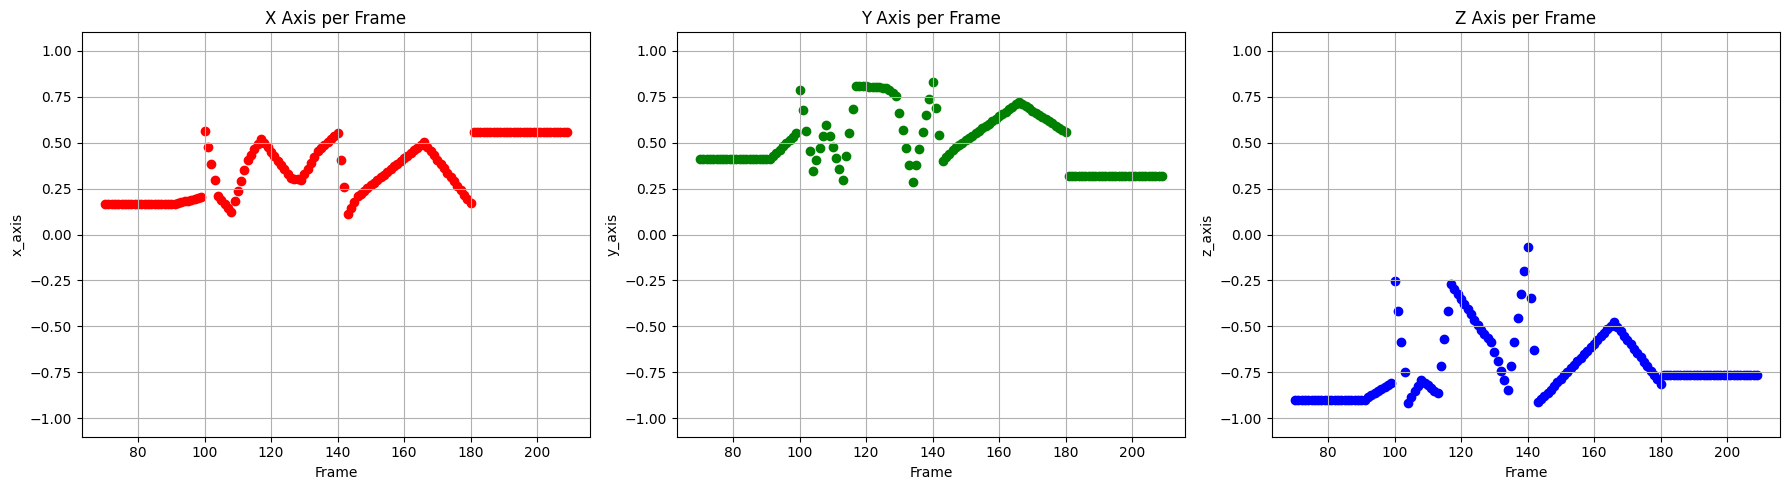

In [284]:
df_original = pd.read_csv(INPUT_ORIGINAL_CSV)

result_df = interpolate_axes_from_b(filtered_df, df_original)
show_plots(result_df)

In [285]:
print(result_df.loc[result_df['frame'] == 106, ['x_axis', 'y_axis', 'z_axis']])

       x_axis    y_axis    z_axis
106  0.165814  0.471038 -0.853907


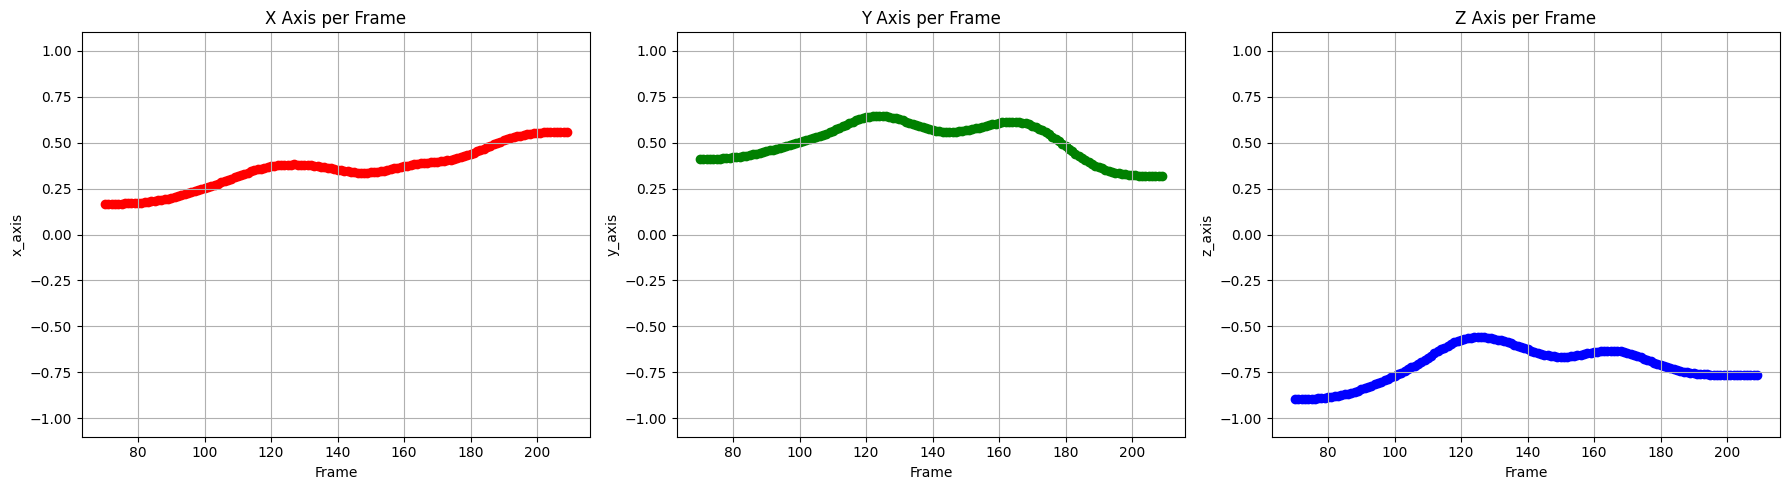

In [286]:
from scipy.ndimage import gaussian_filter1d

sigma = 10
smoothed_df = result_df.copy()

for axis in ['x_axis', 'y_axis', 'z_axis']:
    original = result_df[axis]
    smoothed = original.copy()

    # Find contiguous non-NaN segments
    not_nan = original.notna()
    group = (not_nan != not_nan.shift()).cumsum()
    
    for grp_id, is_valid in group[not_nan].groupby(group):
        segment_indices = is_valid.index
        segment_values = original.loc[segment_indices]

        # Interpolate within segment (optional if there are still NaNs)
        interpolated = segment_values.interpolate()
        # Apply smoothing only to that segment
        smoothed_segment = gaussian_filter1d(interpolated, sigma=sigma, mode='nearest')

        # Assign back to output
        smoothed.loc[segment_indices] = smoothed_segment

    # Store in result
    smoothed_df[axis] = smoothed

show_plots(smoothed_df)

In [287]:
print(smoothed_df.loc[smoothed_df['frame'] == 82, ['x_axis', 'y_axis', 'z_axis']])

      x_axis    y_axis    z_axis
82  0.175907  0.423718 -0.880641


In [288]:
def enforce_non_decreasing_x_axis(df):
    if 'x_axis' not in df.columns:
        raise ValueError("The DataFrame must contain a column named 'x_axis'")

    last_valid = df.loc[0, 'x_axis']
    for i in range(1, len(df)):
        if df.loc[i, 'x_axis'] < last_valid:
            df.loc[i, 'x_axis'] = last_valid
        else:
            last_valid = df.loc[i, 'x_axis']
    
    return df

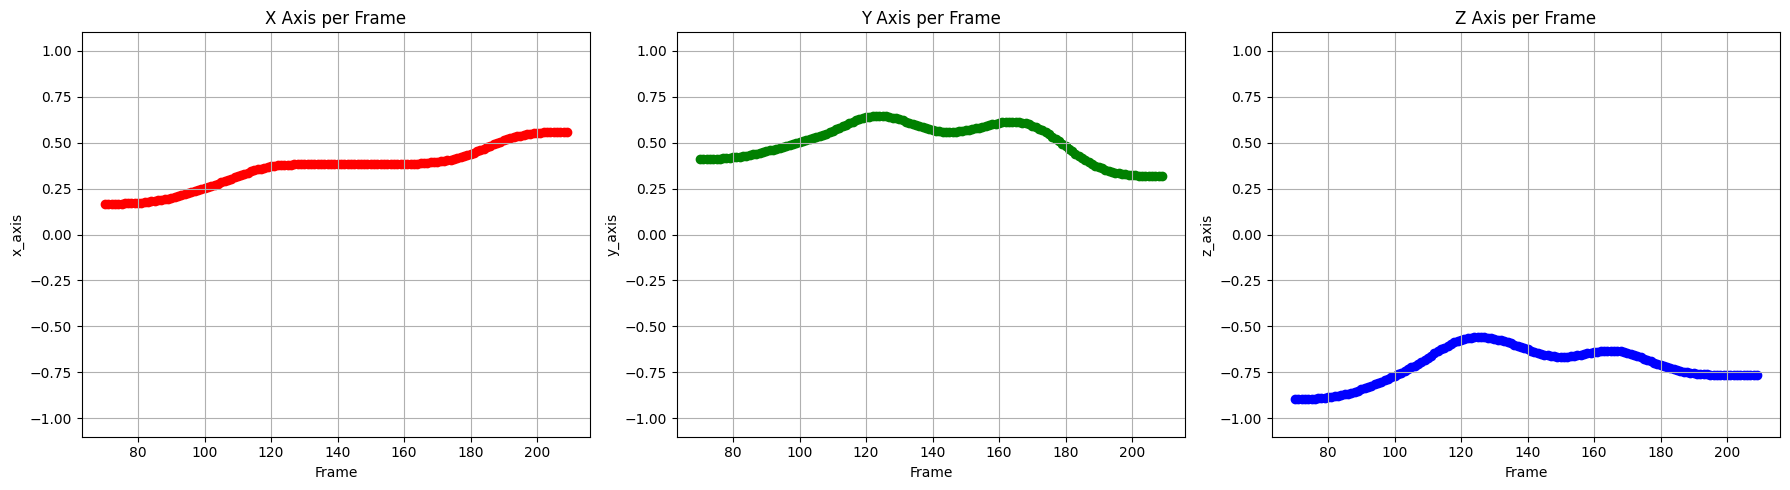

In [289]:
smoothed_df = enforce_non_decreasing_x_axis(smoothed_df)
show_plots(smoothed_df)

In [290]:
def scale_x_axis(df):
    df = df.copy()

    # Get index and values of first and last valid x_axis
    valid_x = df['x_axis'].dropna()
    if valid_x.empty:
        return df  # nothing to scale

    first_idx = valid_x.index[0]
    last_idx = valid_x.index[-1]
    x_start = valid_x.iloc[0]
    x_end = 1 / valid_x.iloc[-1]
    num_rows = last_idx - first_idx + 1

    # Generate scale factors
    scale_factors = np.linspace(x_start, x_end, num_rows)

    # Apply scaling
    df.loc[first_idx:last_idx, 'x_axis'] = df.loc[first_idx:last_idx, 'x_axis'] * scale_factors

    return df

def scale_y_axis(df):
    df = df.copy()

    # Get index and values of first and last valid y_axis
    valid_y = df['y_axis'].dropna()
    if valid_y.empty:
        return df  # nothing to scale

    first_idx = valid_y.index[0]
    last_idx = valid_y.index[-1]
    y_start = 1
    y_end = 0
    num_rows = last_idx - first_idx + 1

    # Generate scale factors from y_start to y_end
    scale_factors = np.linspace(y_start, y_end, num_rows)

    # Apply scaling
    df.loc[first_idx:last_idx, 'y_axis'] = df.loc[first_idx:last_idx, 'y_axis'] * scale_factors

    return df


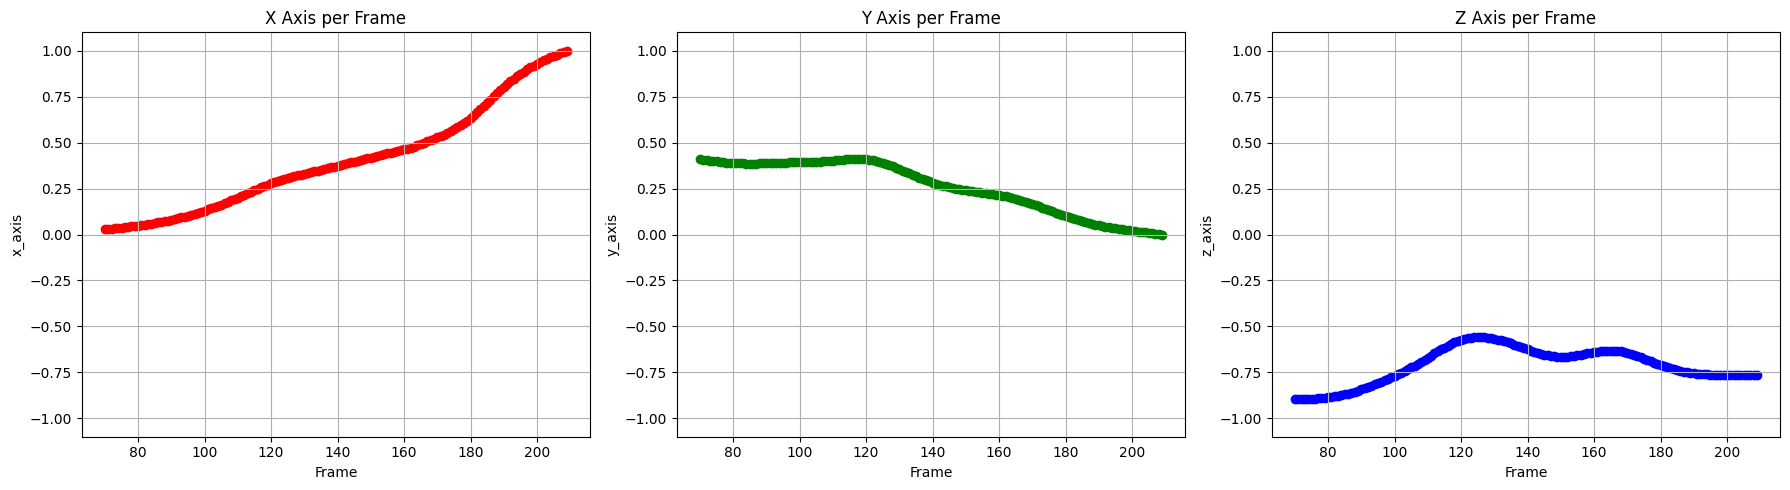

In [291]:
df_scaled = scale_x_axis(smoothed_df)
df_scaled = scale_y_axis(df_scaled)

show_plots(df_scaled)

In [292]:
def compute_z_axis_from_xy(df):
    df = df.copy()
    
    # Compute 1 - x^2 - y^2
    squared_sum = df['x_axis']**2 + df['y_axis']**2
    z_values = 1 - squared_sum

    # Handle invalid values (e.g., where 1 - x^2 - y^2 < 0)
    z_values[z_values < 0] = np.nan

    # Calculate z = sqrt(1 - x^2 - y^2)
    if y_axis_avg < 0:
        df['z_axis'] = np.sqrt(z_values)
    else:
        df['z_axis'] = -np.sqrt(z_values)

    return df

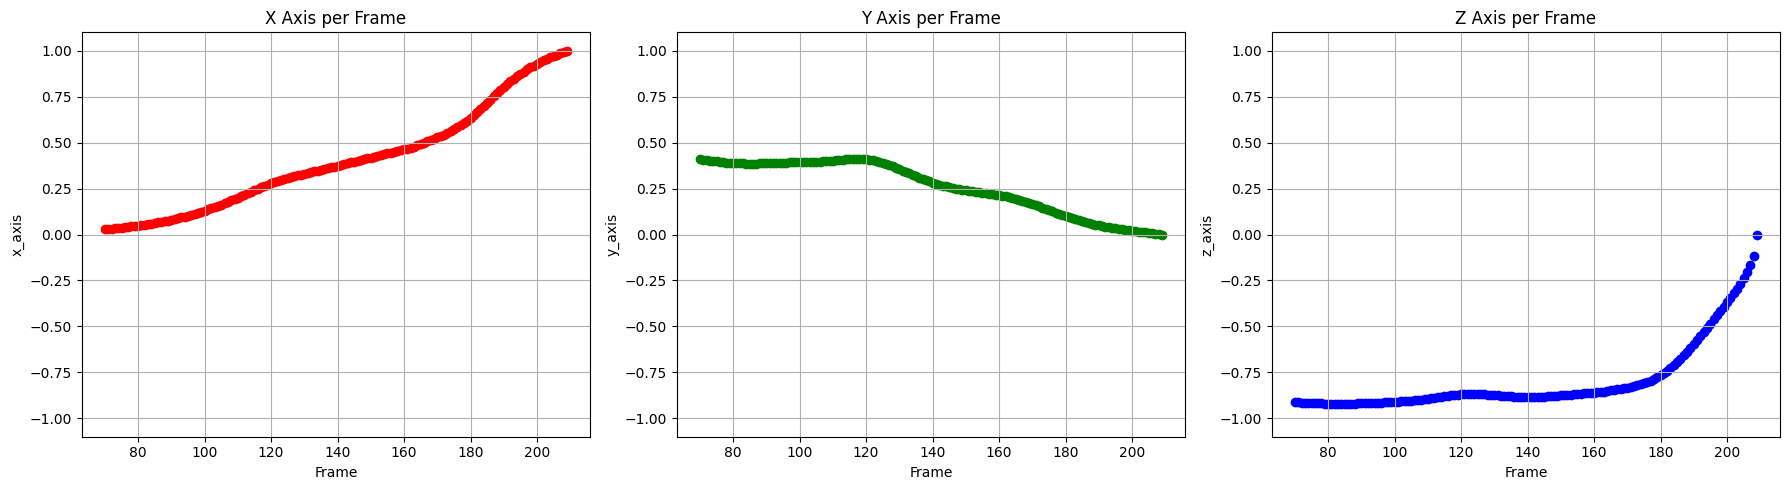

In [293]:
df_processed = compute_z_axis_from_xy(df_scaled)

show_plots(df_processed)

In [294]:
print(df_processed.loc[[103, 104, 105, 106, 107, 108, 109, 110]])

     frame       x      y  radius    x_axis    y_axis    z_axis     angle
103    103  1250.0  460.0    39.0  0.149405  0.394712 -0.906576       NaN
104    104  1253.0  454.0    39.0  0.156259  0.395336 -0.905148  0.467429
105    105  1256.0  450.0    38.0  0.163326  0.396096 -0.903567       NaN
106    106     NaN    NaN     NaN  0.170595  0.397015 -0.901819       NaN
107    107  1266.0  439.0    37.0  0.178056  0.398102 -0.899895       NaN
108    108  1270.0  432.0    37.0  0.185688  0.399357 -0.897794  0.175752
109    109  1273.0  427.0    36.0  0.193469  0.400763 -0.895522       NaN
110    110  1275.0  423.0    36.0  0.201366  0.402289 -0.893093       NaN


In [295]:
# Create a mask for rows where A has NaN in all three columns and B has valid values
mask = (
    df_processed['x'].isna() & df_processed['y'].isna() & df_processed['radius'].isna() &
    df_original['x'].notna() & df_original['y'].notna() & df_original['radius'].notna()
)

# Update A with values from B where the mask is True
df_processed.loc[mask, ['x', 'y', 'radius']] = df_original.loc[mask, ['x', 'y', 'radius']]

print(df_processed.loc[[103, 104, 105, 106, 107, 108, 109, 110]])

     frame       x      y  radius    x_axis    y_axis    z_axis     angle
103    103  1250.0  460.0    39.0  0.149405  0.394712 -0.906576       NaN
104    104  1253.0  454.0    39.0  0.156259  0.395336 -0.905148  0.467429
105    105  1256.0  450.0    38.0  0.163326  0.396096 -0.903567       NaN
106    106  1260.0  444.0    38.0  0.170595  0.397015 -0.901819       NaN
107    107  1266.0  439.0    37.0  0.178056  0.398102 -0.899895       NaN
108    108  1270.0  432.0    37.0  0.185688  0.399357 -0.897794  0.175752
109    109  1273.0  427.0    36.0  0.193469  0.400763 -0.895522       NaN
110    110  1275.0  423.0    36.0  0.201366  0.402289 -0.893093       NaN


### Post-processing angle

In [296]:
def plot_angle_over_index(df, title="Angle Over Index"):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['angle'], label='Angle', color='blue')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [297]:
def remove_outliers(series, threshold=1):
    # Apply an outlier removal using z-score
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    outliers_z = abs(z_scores) > threshold  # Consider values with z-score > threshold as outliers
    series[outliers_z] = np.nan

    return series

In [298]:
def smooth_series(series, first_valid_index, last_valid_index, window=5):
    # Copia per non modificare l'originale
    smoothed = series.copy()

    # Applichi il rolling solo tra i validi
    rolled = series[first_valid_index:last_valid_index+1] \
        .rolling(window=window, center=True) \
        .mean()

    # Interpolazione per stimare i bordi più precisamente
    rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

    smoothed[first_valid_index:last_valid_index+1] = rolled

    # Rimetti i valori smussati nella serie originale
    series.loc[first_valid_index:last_valid_index] = smoothed
    return series

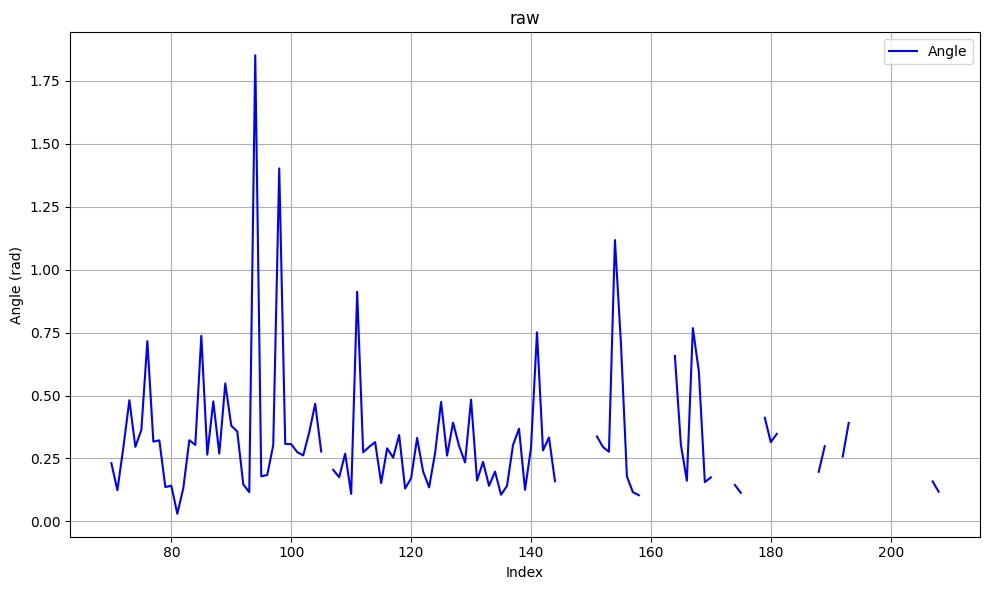

In [299]:
plot_angle_over_index(df, title="raw")

/tmp/ipykernel_40571/3499710534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[outliers_z] = np.nan


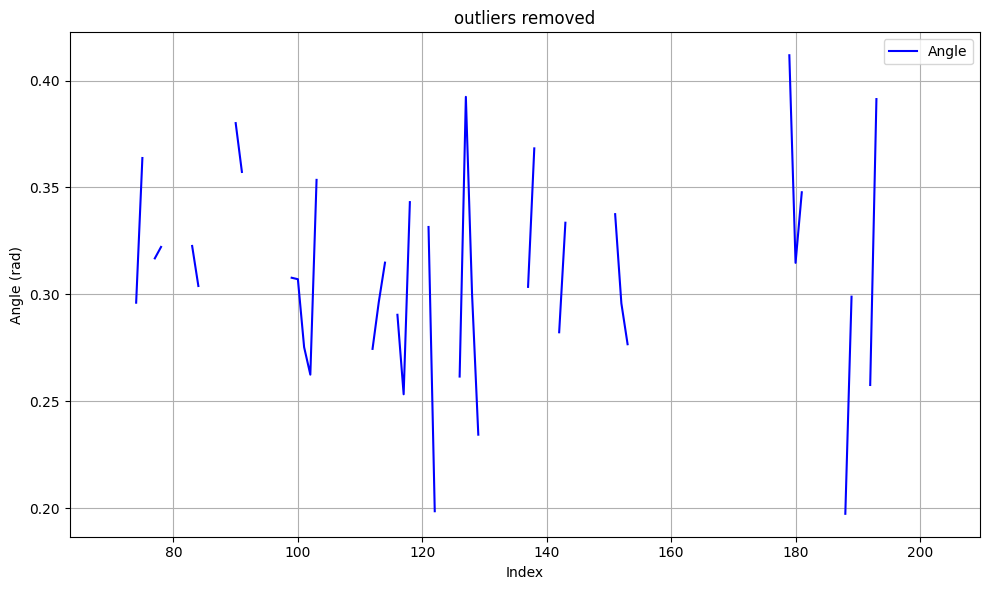

In [300]:
# Remove outliers
df['angle'] = remove_outliers(df['angle'], threshold=0.5)
plot_angle_over_index(df, title="outliers removed")

First valid index: 70, Last valid index: 209


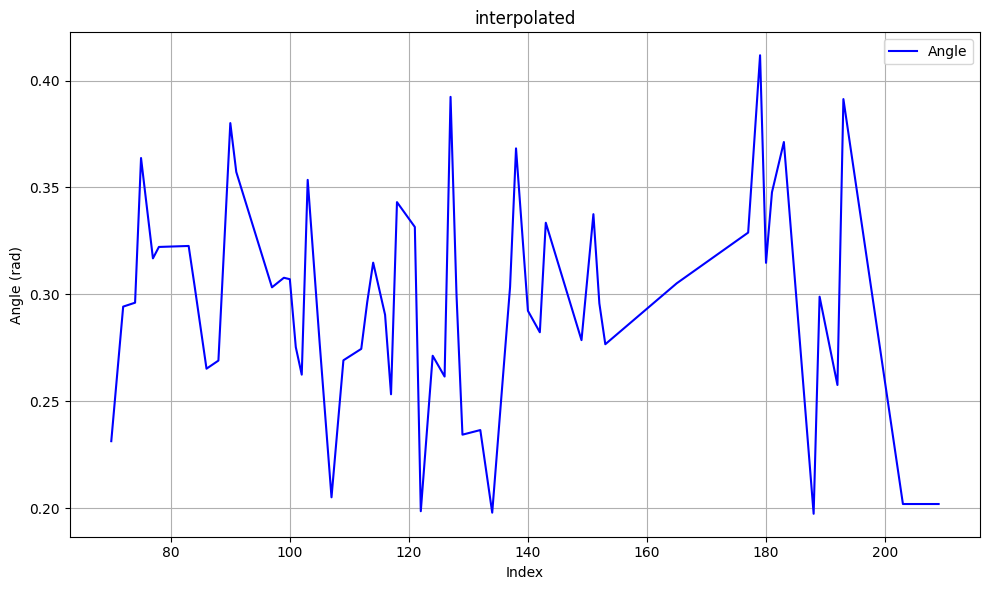

In [301]:
# Find the first and last non-NaN indices
first_valid_index = df_processed['x'].first_valid_index()
last_valid_index = df_processed['x'].last_valid_index()
print(f"First valid index: {first_valid_index}, Last valid index: {last_valid_index}")
# Only interpolate between them
df.loc[first_valid_index:last_valid_index, 'angle'] = (
    df.loc[first_valid_index:last_valid_index, 'angle']
    .interpolate(method='linear', limit_direction='both')
)
plot_angle_over_index(df, title="interpolated")

/tmp/ipykernel_40571/4293600903.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_40571/4293600903.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[first_valid_index:last_valid_index] = smoothed


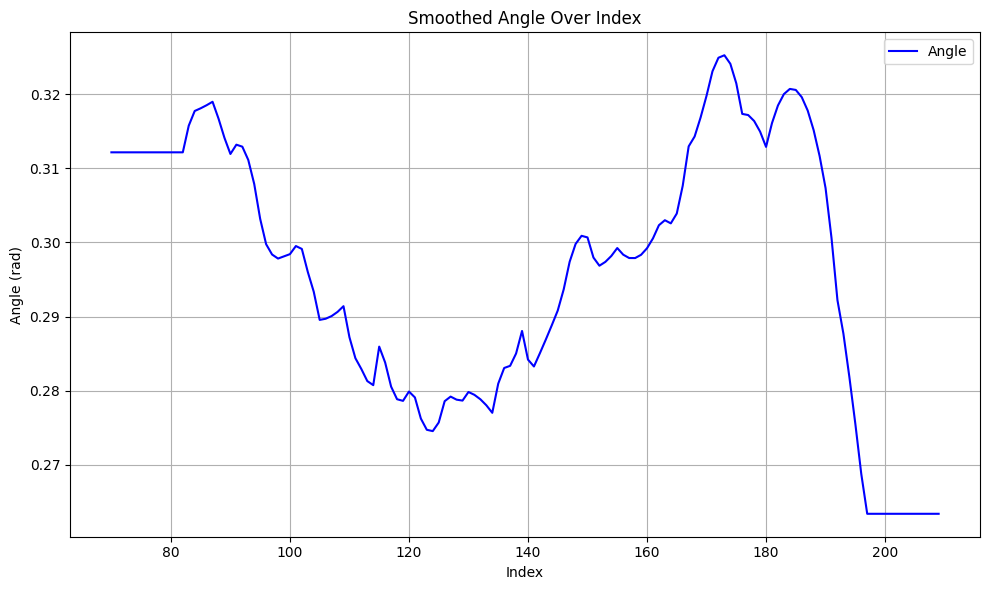

In [302]:
# Smooth the data
df['angle'] = smooth_series(df['angle'], first_valid_index, last_valid_index, window=25)

plot_angle_over_index(df, title="Smoothed Angle Over Index")

/tmp/ipykernel_40571/4293600903.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_40571/4293600903.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[first_valid_index:last_valid_index] = smoothed


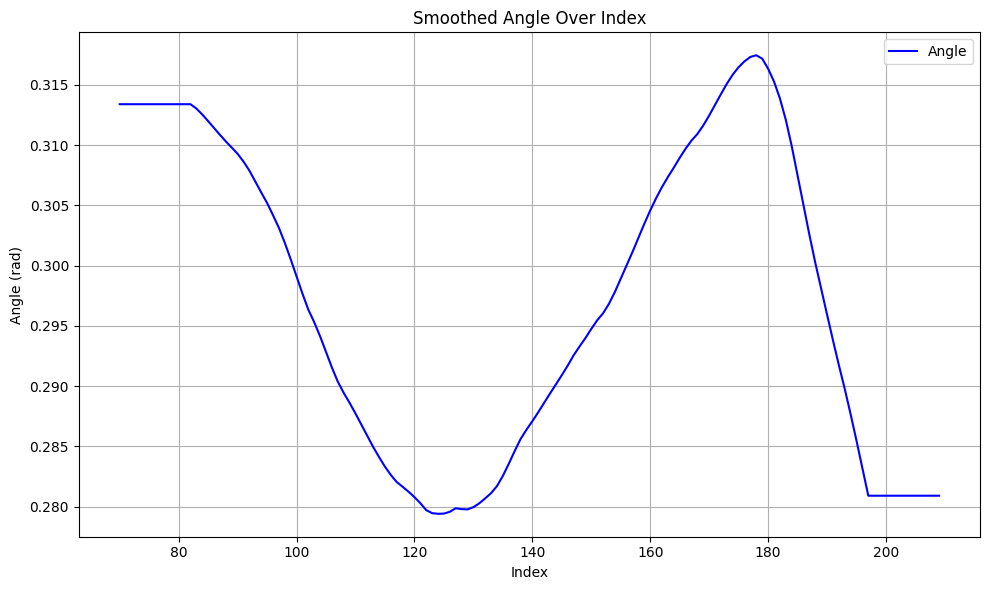

In [303]:
# Smooth the data
df['angle'] = smooth_series(df['angle'], first_valid_index, last_valid_index, window=25)

plot_angle_over_index(df, title="Smoothed Angle Over Index")

In [304]:
df_processed['angle'] = df['angle']
print(df_processed.loc[[103, 104, 105, 106, 107, 108, 109, 110]])

     frame       x      y  radius    x_axis    y_axis    z_axis     angle
103    103  1250.0  460.0    39.0  0.149405  0.394712 -0.906576  0.295307
104    104  1253.0  454.0    39.0  0.156259  0.395336 -0.905148  0.294131
105    105  1256.0  450.0    38.0  0.163326  0.396096 -0.903567  0.292836
106    106  1260.0  444.0    38.0  0.170595  0.397015 -0.901819  0.291545
107    107  1266.0  439.0    37.0  0.178056  0.398102 -0.899895  0.290375
108    108  1270.0  432.0    37.0  0.185688  0.399357 -0.897794  0.289443
109    109  1273.0  427.0    36.0  0.193469  0.400763 -0.895522  0.288616
110    110  1275.0  423.0    36.0  0.201366  0.402289 -0.893093  0.287731


In [305]:
OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Rotation_data_processed_{VIDEO_NUMBER}.csv")
df_processed.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Saved rotation data to {OUTPUT_CSV_PATH}")

Saved rotation data to /home/davic/projects/IACV_project/bowling-analysis/notebook/spin/intermediate_data/Rotation_data_processed_7.csv
